In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV,KFold,cross_val_score,RandomizedSearchCV
from sklearn.metrics import accuracy_score,roc_curve, auc,classification_report,confusion_matrix
from imblearn.over_sampling import SMOTE

# Read Dataset

In [4]:
df_fraud=pd.read_csv('fraud_dataset_example.csv')
display(df_fraud.head())
print(df_fraud.info())

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101613 entries, 0 to 101612
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   step            101613 non-null  int64  
 1   type            101613 non-null  object 
 2   amount          101613 non-null  float64
 3   nameOrig        101613 non-null  object 
 4   oldbalanceOrg   101613 non-null  float64
 5   newbalanceOrig  101613 non-null  float64
 6   nameDest        101613 non-null  object 
 7   oldbalanceDest  101613 non-null  float64
 8   newbalanceDest  101613 non-null  float64
 9   isFraud         101613 non-null  int64  
 10  isFlaggedFraud  101613 non-null  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 8.5+ MB
None


# Create New Columns

New columns are created to add information to the model. Such as, the first letter and the lenght of every bank account. 

In [7]:
df_fraud['first_letter_nameDest'] = df_fraud['nameDest'].str[0]
df_fraud['nameDest_length'] = df_fraud['nameDest'].str.len()

In [9]:
df_fraud['first_letter_nameOrig'] = df_fraud['nameOrig'].str[0]
df_fraud['nameOrig_length'] = df_fraud['nameOrig'].str.len()

# Variable Descriptions:

- **step**: Unit of time (1 hour).
  
- **type**: Type of transaction, which can be one of the following:
  - `CASH-IN`
  - `CASH-OUT`
  - `DEBIT`
  - `PAYMENT`
  - `TRANSFER`

- **amount**: Transaction amount in local currency.

- **nameOrig**: Transaction originator (the account initiating the transaction).

- **oldbalanceOrg**: Initial balance (before the transaction) of the originator's account.

- **newbalanceOrig**: New balance (after the transaction) of the originator's account.

- **nameDest**: Transaction recipient (the account receiving the transaction).

- **oldbalanceDest**: Initial balance (before the transaction) of the recipient's account.

- **newbalanceDest**: New balance (after the transaction) of the recipient's account.

- **isFraud**: Indicates whether the transaction is fraudulent. A fraud agent takes control of a customer's account and attempts to empty it by transferring funds to another account and then cashing out.

- **isFlaggedFraud**: Indicates an illegal attempt to transfer a massive amount of money in a single transaction.

- **first_letter_nameDest**: Destination Account Name first character.

- **nameDest_length**: Destination Account Name Lenght

- **first_letter_nameOrig**: Origin Account Name first character

- **nameOrig_length**: Origin Account Name Lenght


In [12]:
same_account_transactions = df_fraud[df_fraud['nameOrig'] == df_fraud['nameDest']]
num_same_account_transactions = same_account_transactions.shape[0]

print(f"Number of transactions where the origin and destination account are the same: {num_same_account_transactions}")

Number of transactions where the origin and destination account are the same: 0


# Descriptive Analysis

## Fraud Distribution

isFraud
0    101497
1       116
Name: count, dtype: int64

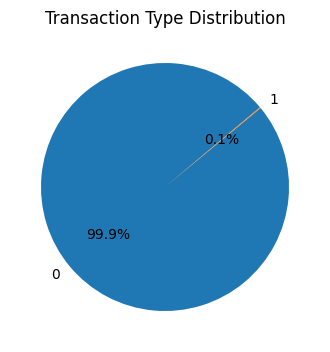

In [16]:
display(df_fraud.isFraud.value_counts())

fraud_counts = df_fraud['isFraud'].value_counts()

plt.figure(figsize=(4, 5))
plt.pie(fraud_counts, labels=fraud_counts.index, autopct='%1.1f%%', startangle=40)

plt.title('Transaction Type Distribution')

plt.show()

When predicting the class of the Fraud variable, there is a significant **imbalance** in the number of values for each class

## Flagged Fraud Distribution

isFlaggedFraud
0    101613
Name: count, dtype: int64

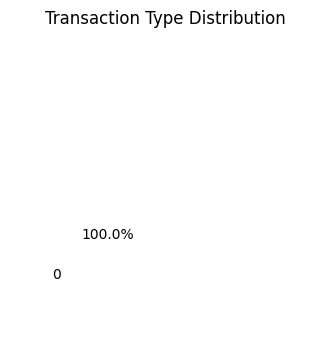

In [20]:
display(df_fraud.isFlaggedFraud.value_counts())

ffraud_counts = df_fraud['isFlaggedFraud'].value_counts()

plt.figure(figsize=(4, 5))
plt.pie(ffraud_counts, labels=ffraud_counts.index, autopct='%1.1f%%', startangle=40)

plt.title('Transaction Type Distribution')

plt.show()

We should consider **eliminating** this variable, as it doesn't give any valuable information to the model

## Step

step
9     37628
10    28887
8     21097
7      6837
1      2708
6      1660
2      1014
5       665
4       565
3       552
Name: count, dtype: int64

C:\Users\PC\AppData\Local\Temp\ipykernel_12192\3961799890.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='step', data=df_fraud, palette='muted')


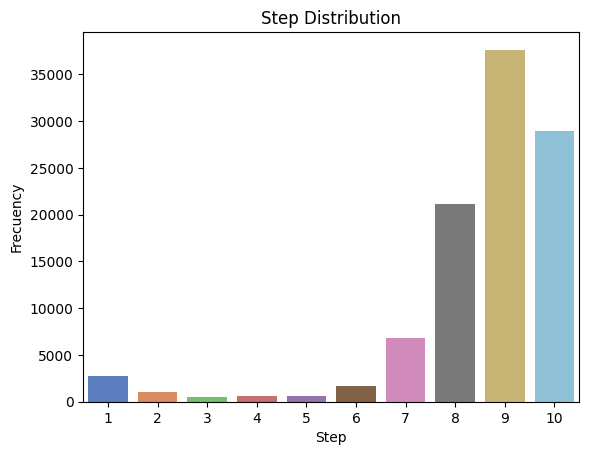

C:\Users\PC\AppData\Local\Temp\ipykernel_12192\3961799890.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='step', data=df_no_fraud, palette='muted', ax=axes[0])
C:\Users\PC\AppData\Local\Temp\ipykernel_12192\3961799890.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='step', data=df_fraud_only, palette='muted', ax=axes[1])


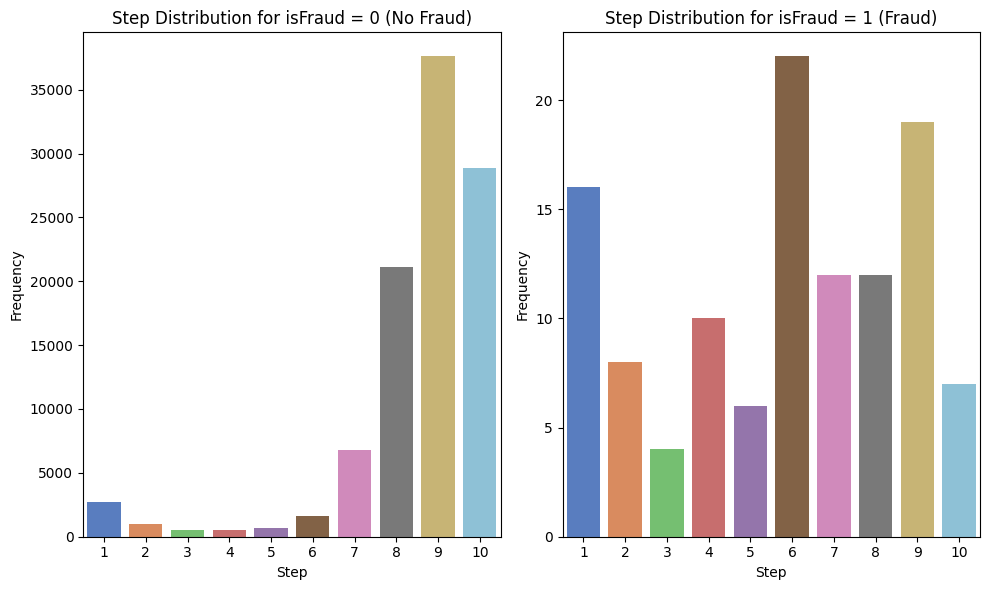

Fraud=0


step
9     37609
10    28880
8     21085
7      6825
1      2692
6      1638
2      1006
5       659
4       555
3       548
Name: count, dtype: int64

Fraud=1


step
6     22
9     19
1     16
7     12
8     12
4     10
2      8
10     7
5      6
3      4
Name: count, dtype: int64

In [24]:
display(df_fraud.step.value_counts())

sns.countplot(x='step', data=df_fraud, palette='muted')
plt.title('Step Distribution')
plt.xlabel('Step')
plt.ylabel('Frecuency')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

df_no_fraud = df_fraud[df_fraud['isFraud'] == 0]
df_fraud_only = df_fraud[df_fraud['isFraud'] == 1]

sns.countplot(x='step', data=df_no_fraud, palette='muted', ax=axes[0])
axes[0].set_title('Step Distribution for isFraud = 0 (No Fraud)')
axes[0].set_xlabel('Step')
axes[0].set_ylabel('Frequency')

sns.countplot(x='step', data=df_fraud_only, palette='muted', ax=axes[1])
axes[1].set_title('Step Distribution for isFraud = 1 (Fraud)')
axes[1].set_xlabel('Step')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("Fraud=0")
display(df_no_fraud.step.value_counts())

print("Fraud=1")
display(df_fraud_only.step.value_counts())

The distribution for fraudulent transactions is more **evenly spread** across all the values of step. It is true that Frudulent transactions are not mainly done for the least common values of non-fraudulent, but it could be useful to be on alert for those less common values of step.

## Transaction Type

type
PAYMENT     40062
CASH_OUT    31310
CASH_IN     20540
TRANSFER     8689
DEBIT        1012
Name: count, dtype: int64

C:\Users\PC\AppData\Local\Temp\ipykernel_12192\289093615.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='type', data=df_fraud, palette='muted')


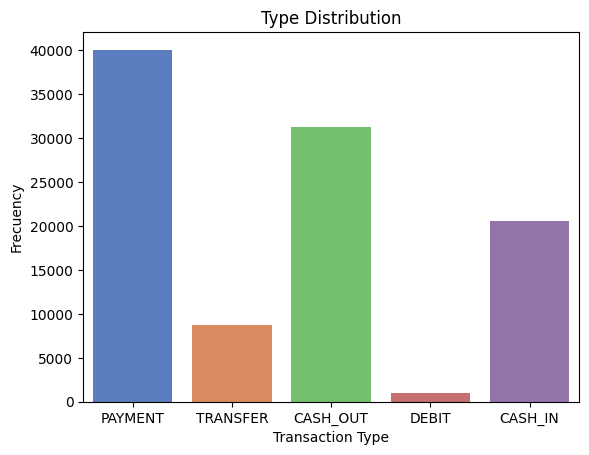

C:\Users\PC\AppData\Local\Temp\ipykernel_12192\289093615.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='type', data=df_no_fraud, palette='muted', ax=axes[0])
C:\Users\PC\AppData\Local\Temp\ipykernel_12192\289093615.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='type', data=df_fraud_only, palette='muted', ax=axes[1])


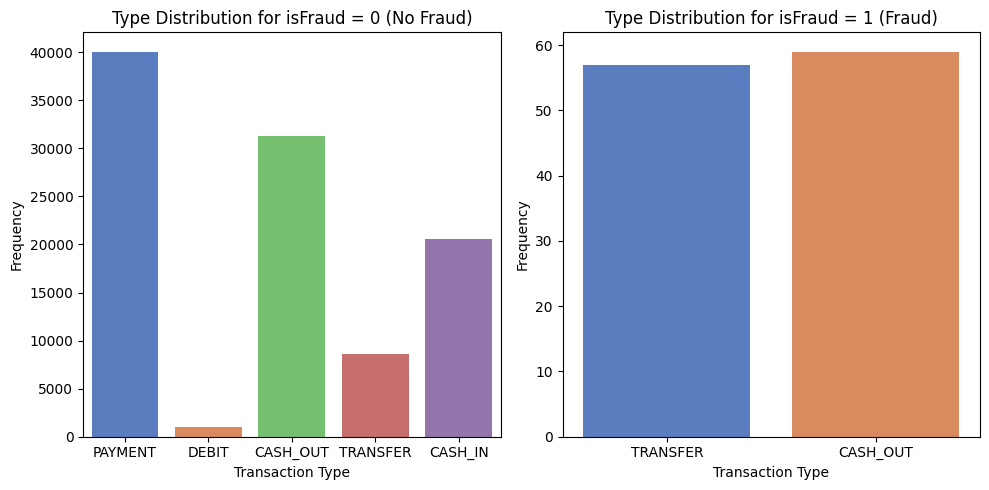

Fraud=0


type
PAYMENT     40062
CASH_OUT    31251
CASH_IN     20540
TRANSFER     8632
DEBIT        1012
Name: count, dtype: int64

Fraud=1


type
CASH_OUT    59
TRANSFER    57
Name: count, dtype: int64

In [28]:
display(df_fraud.type.value_counts())

sns.countplot(x='type', data=df_fraud, palette='muted')
plt.title('Type Distribution')
plt.xlabel('Transaction Type')
plt.ylabel('Frecuency')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(x='type', data=df_no_fraud, palette='muted', ax=axes[0])
axes[0].set_title('Type Distribution for isFraud = 0 (No Fraud)')
axes[0].set_xlabel('Transaction Type')
axes[0].set_ylabel('Frequency')

sns.countplot(x='type', data=df_fraud_only, palette='muted', ax=axes[1])
axes[1].set_title('Type Distribution for isFraud = 1 (Fraud)')
axes[1].set_xlabel('Transaction Type')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("Fraud=0")
display(df_no_fraud.type.value_counts())

print("Fraud=1")
display(df_fraud_only.type.value_counts())

Fraud only occurs with transactions such as **Transfer** and **Cash Out**

## Destination Account

In [32]:
df_fraud_only.nameDest.value_counts()

nameDest
C410033330     2
C38997010      1
C553264065     1
C1007251739    1
C1848415041    1
              ..
C571514738     1
C1262577882    1
C2104652067    1
C2010733400    1
C2020337583    1
Name: count, Length: 115, dtype: int64

Only **1** of the Destination Accounts which commit Fraud is repeated

### First Letter 

first_letter_nameDest
C    61551
M    40062
Name: count, dtype: int64

C:\Users\PC\AppData\Local\Temp\ipykernel_12192\1707517615.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='first_letter_nameDest', data=df_fraud, palette='muted')


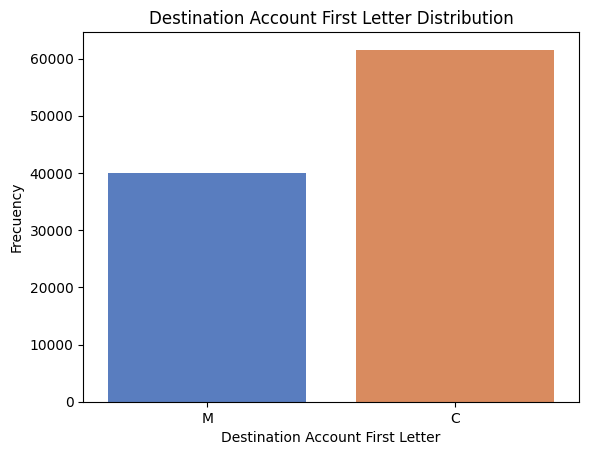

C:\Users\PC\AppData\Local\Temp\ipykernel_12192\1707517615.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='first_letter_nameDest', data=df_no_fraud, palette='muted', ax=axes[0])
C:\Users\PC\AppData\Local\Temp\ipykernel_12192\1707517615.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='first_letter_nameDest', data=df_fraud_only, palette='muted', ax=axes[1])


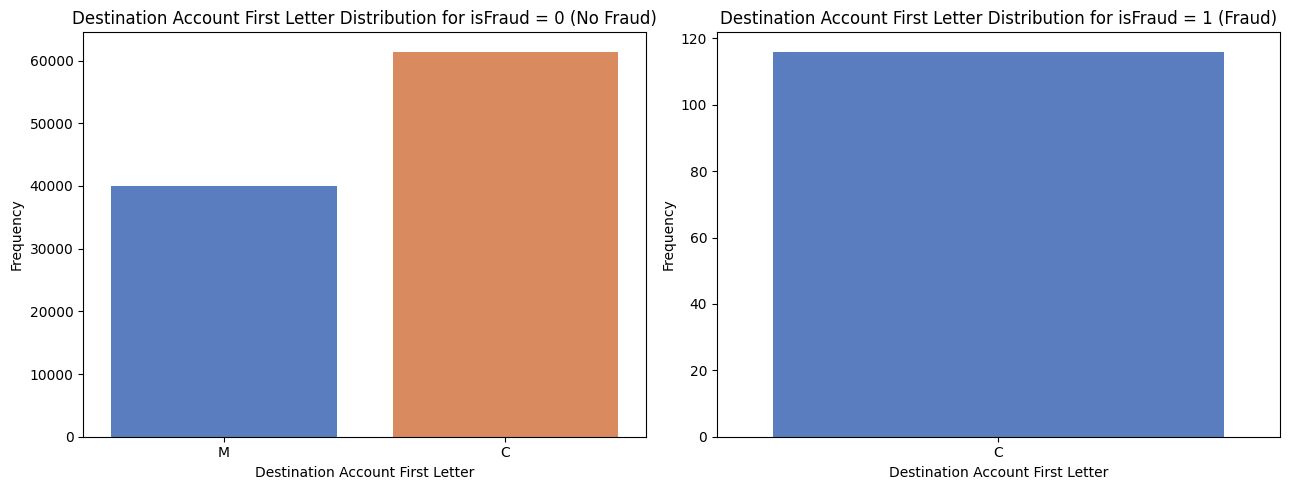

Fraud=0


first_letter_nameDest
C    61435
M    40062
Name: count, dtype: int64

Fraud=1


first_letter_nameDest
C    116
Name: count, dtype: int64

In [36]:
display(df_fraud.first_letter_nameDest.value_counts())

sns.countplot(x='first_letter_nameDest', data=df_fraud, palette='muted')
plt.title('Destination Account First Letter Distribution')
plt.xlabel('Destination Account First Letter')
plt.ylabel('Frecuency')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

sns.countplot(x='first_letter_nameDest', data=df_no_fraud, palette='muted', ax=axes[0])
axes[0].set_title('Destination Account First Letter Distribution for isFraud = 0 (No Fraud)')
axes[0].set_xlabel('Destination Account First Letter')
axes[0].set_ylabel('Frequency')

sns.countplot(x='first_letter_nameDest', data=df_fraud_only, palette='muted', ax=axes[1])
axes[1].set_title('Destination Account First Letter Distribution for isFraud = 1 (Fraud)')
axes[1].set_xlabel('Destination Account First Letter')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("Fraud=0")
display(df_no_fraud.first_letter_nameDest.value_counts())

print("Fraud=1")
display(df_fraud_only.first_letter_nameDest.value_counts())

All destination accounts involved in fraud begin with the letter **C**

### Account Name Lenght

nameDest_length
11    54655
10    42164
9      4360
8       382
7        45
4         7
Name: count, dtype: int64

C:\Users\PC\AppData\Local\Temp\ipykernel_12192\3166121821.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='nameDest_length', data=df_fraud, palette='muted')


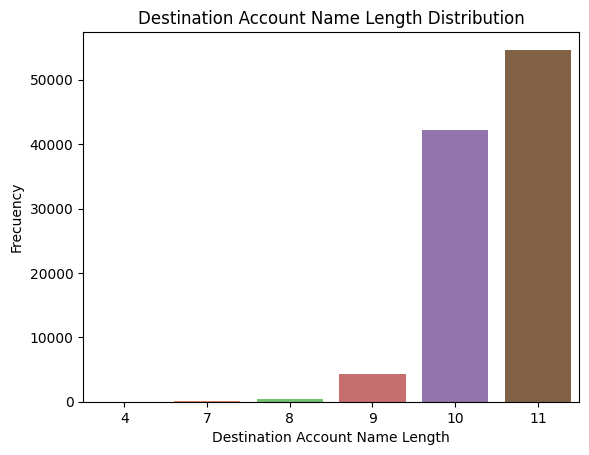

C:\Users\PC\AppData\Local\Temp\ipykernel_12192\3166121821.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='nameDest_length', data=df_no_fraud, palette='muted', ax=axes[0])
C:\Users\PC\AppData\Local\Temp\ipykernel_12192\3166121821.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='nameDest_length', data=df_fraud_only, palette='muted', ax=axes[1])


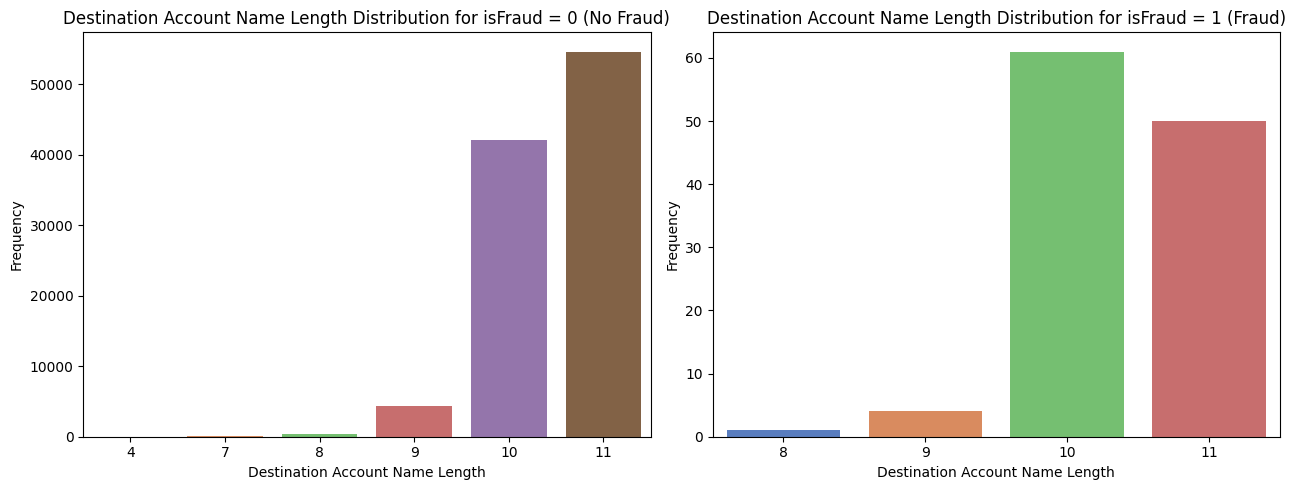

Fraud=0


nameDest_length
11    54605
10    42103
9      4356
8       381
7        45
4         7
Name: count, dtype: int64

Fraud=1


nameDest_length
10    61
11    50
9      4
8      1
Name: count, dtype: int64

In [40]:
display(df_fraud.nameDest_length.value_counts())

sns.countplot(x='nameDest_length', data=df_fraud, palette='muted')
plt.title('Destination Account Name Length Distribution')
plt.xlabel('Destination Account Name Length')
plt.ylabel('Frecuency')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

sns.countplot(x='nameDest_length', data=df_no_fraud, palette='muted', ax=axes[0])
axes[0].set_title('Destination Account Name Length Distribution for isFraud = 0 (No Fraud)')
axes[0].set_xlabel('Destination Account Name Length')
axes[0].set_ylabel('Frequency')

sns.countplot(x='nameDest_length', data=df_fraud_only, palette='muted', ax=axes[1])
axes[1].set_title('Destination Account Name Length Distribution for isFraud = 1 (Fraud)')
axes[1].set_xlabel('Destination Account Name Length')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("Fraud=0")
display(df_no_fraud.nameDest_length.value_counts())

print("Fraud=1")
display(df_fraud_only.nameDest_length.value_counts())

There are no account names with fewer than **8 characters** when committing fraud. It would have been a good indicator to detect fraud if the length of the account names attempting fraud had been less common, such as 4 or 7 characters, which is less typical in non-fraud transactions.

## Origin Account

In [44]:
df_fraud_only.nameOrig.value_counts()

nameOrig
C1305486145    1
C840083671     1
C1420196421    1
C2101527076    1
C137533655     1
              ..
C489647033     1
C481501970     1
C1190429229    1
C1446009472    1
C140359285     1
Name: count, Length: 116, dtype: int64

**None** of the accounts frauded are repeated

### First Letter 

first_letter_nameOrig
C    101613
Name: count, dtype: int64

C:\Users\PC\AppData\Local\Temp\ipykernel_12192\370242461.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='first_letter_nameOrig', data=df_fraud, palette='muted')


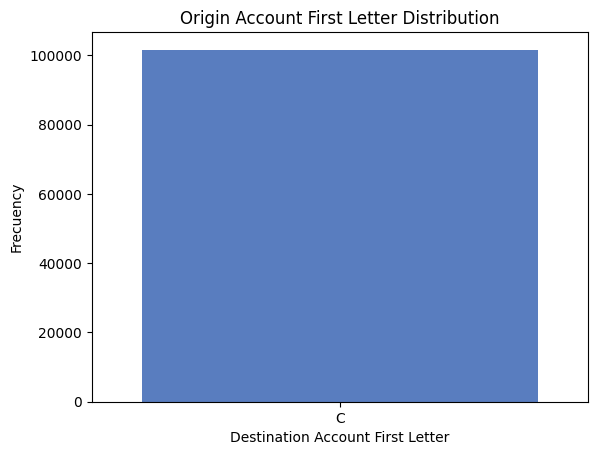

In [48]:
display(df_fraud.first_letter_nameOrig.value_counts())

sns.countplot(x='first_letter_nameOrig', data=df_fraud, palette='muted')
plt.title('Origin Account First Letter Distribution')
plt.xlabel('Destination Account First Letter')
plt.ylabel('Frecuency')
plt.show()

All Origin accounts start with **C**

### Account Name Lenght

nameOrig_length
11    54227
10    42636
9      4250
8       443
7        52
6         5
Name: count, dtype: int64

C:\Users\PC\AppData\Local\Temp\ipykernel_12192\750037416.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='nameOrig_length', data=df_fraud, palette='muted')


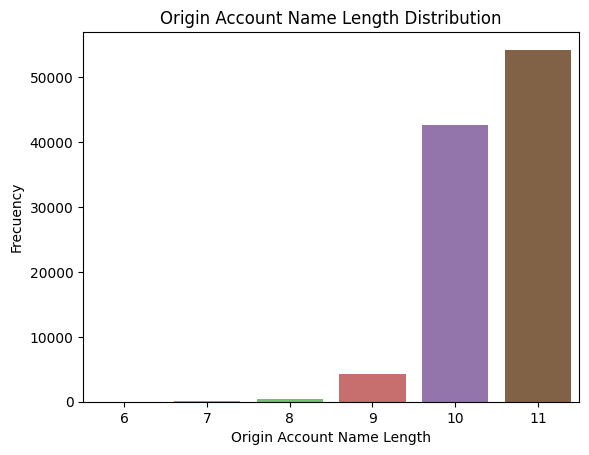

C:\Users\PC\AppData\Local\Temp\ipykernel_12192\750037416.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='nameOrig_length', data=df_no_fraud, palette='muted', ax=axes[0])
C:\Users\PC\AppData\Local\Temp\ipykernel_12192\750037416.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='nameOrig_length', data=df_fraud_only, palette='muted', ax=axes[1])


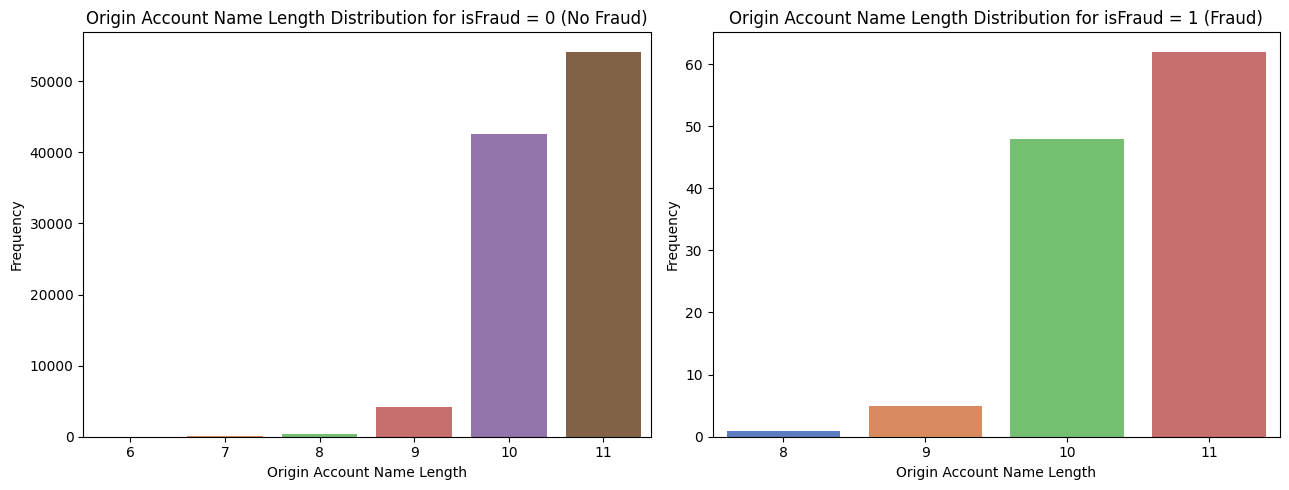

Fraud=0


nameOrig_length
11    54165
10    42588
9      4245
8       442
7        52
6         5
Name: count, dtype: int64

Fraud=1


nameOrig_length
11    62
10    48
9      5
8      1
Name: count, dtype: int64

In [52]:
display(df_fraud.nameOrig_length.value_counts())

sns.countplot(x='nameOrig_length', data=df_fraud, palette='muted')
plt.title('Origin Account Name Length Distribution')
plt.xlabel('Origin Account Name Length')
plt.ylabel('Frecuency')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

sns.countplot(x='nameOrig_length', data=df_no_fraud, palette='muted', ax=axes[0])
axes[0].set_title('Origin Account Name Length Distribution for isFraud = 0 (No Fraud)')
axes[0].set_xlabel('Origin Account Name Length')
axes[0].set_ylabel('Frequency')

sns.countplot(x='nameOrig_length', data=df_fraud_only, palette='muted', ax=axes[1])
axes[1].set_title('Origin Account Name Length Distribution for isFraud = 1 (Fraud)')
axes[1].set_xlabel('Origin Account Name Length')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("Fraud=0")
display(df_no_fraud.nameOrig_length.value_counts())

print("Fraud=1")
display(df_fraud_only.nameOrig_length.value_counts())

There are no account names with fewer than **8 characters** when recibing fraud.  As before, it would have been a good indicator to detect fraud if the length of the account names recibing fraud had been less common, such as 4 or 7 characters, which is less typical in non-fraud transactions.

Amount when No Fraud: Median = 53386.53, Limits = [0, 516078.07000000007]
Amount when Fraud: Median = 39077.815, Limits = [0, 714517.4874999999]


C:\Users\PC\AppData\Local\Temp\ipykernel_12192\2394460348.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='isFraud', y='amount', data=df_fraud,palette="Set1")


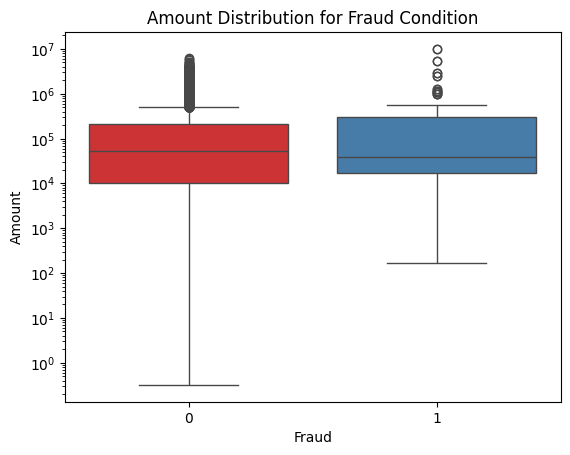

In [55]:
fraud_0 = df_fraud[df_fraud['isFraud'] == 0]
fraud_1 = df_fraud[df_fraud['isFraud'] == 1]

median_amount_0 = fraud_0['amount'].median()
q1_amount_0 = fraud_0['amount'].quantile(0.25)
q3_amount_0 = fraud_0['amount'].quantile(0.75)
iqr_amount_0 = q3_amount_0 - q1_amount_0
lower_limit_amount_0 = max(0, q1_amount_0 - 1.5 * iqr_amount_0)
upper_limit_amount_0 = q3_amount_0 + 1.5 * iqr_amount_0

print(f"Amount when No Fraud: Median = {median_amount_0}, Limits = [{lower_limit_amount_0}, {upper_limit_amount_0}]")

# Calcular estadísticas para 'amount' cuando isFraud=1
median_amount_1 = fraud_1['amount'].median()
q1_amount_1 = fraud_1['amount'].quantile(0.25)
q3_amount_1 = fraud_1['amount'].quantile(0.75)
iqr_amount_1 = q3_amount_1 - q1_amount_1
lower_limit_amount_1 = max(0, q1_amount_1 - 1.5 * iqr_amount_1)
upper_limit_amount_1 = q3_amount_1 + 1.5 * iqr_amount_1

print(f"Amount when Fraud: Median = {median_amount_1}, Limits = [{lower_limit_amount_1}, {upper_limit_amount_1}]")

sns.boxplot(x='isFraud', y='amount', data=df_fraud,palette="Set1")
plt.xlabel("Fraud")
plt.ylabel("Amount")
plt.title("Amount Distribution for Fraud Condition")
plt.yscale('log')  
plt.show()

Quite **similar distributions**

Old Balance of Origin Account when No Fraud: Median = 20181.0, Limits = [0, 486427.64999999997]
Old Balance of Origin Account when Fraud: Median = 30521.02, Limits = [0, 601089.6075]


C:\Users\PC\AppData\Local\Temp\ipykernel_12192\236087291.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='isFraud', y='oldbalanceOrg', data=df_fraud,palette="Set1")


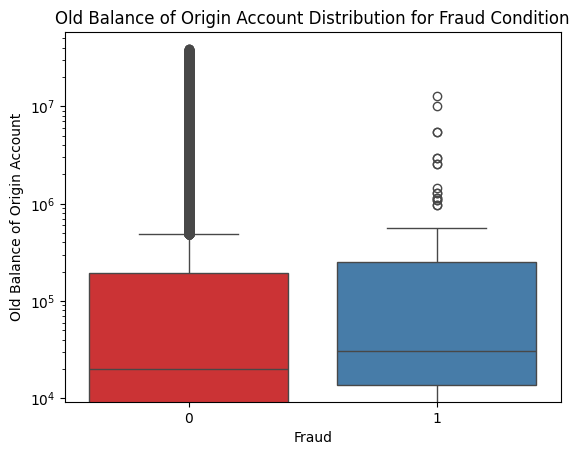

In [58]:
median_oldbalanceOrg_0 = fraud_0['oldbalanceOrg'].median()
q1_oldbalanceOrg_0 = fraud_0['oldbalanceOrg'].quantile(0.25)
q3_oldbalanceOrg_0 = fraud_0['oldbalanceOrg'].quantile(0.75)
iqr_oldbalanceOrg_0 = q3_oldbalanceOrg_0 - q1_oldbalanceOrg_0
lower_limit_oldbalanceOrg_0 = max(0, q1_oldbalanceOrg_0 - 1.5 * iqr_oldbalanceOrg_0)
upper_limit_oldbalanceOrg_0 = q3_oldbalanceOrg_0 + 1.5 * iqr_oldbalanceOrg_0

print(f"Old Balance of Origin Account when No Fraud: Median = {median_oldbalanceOrg_0}, Limits = [{lower_limit_oldbalanceOrg_0}, {upper_limit_oldbalanceOrg_0}]")

median_oldbalanceOrg_1 = fraud_1['oldbalanceOrg'].median()
q1_oldbalanceOrg_1 = fraud_1['oldbalanceOrg'].quantile(0.25)
q3_oldbalanceOrg_1 = fraud_1['oldbalanceOrg'].quantile(0.75)
iqr_oldbalanceOrg_1 = q3_oldbalanceOrg_1 - q1_oldbalanceOrg_1
lower_limit_oldbalanceOrg_1 = max(0, q1_oldbalanceOrg_1 - 1.5 * iqr_oldbalanceOrg_1)
upper_limit_oldbalanceOrg_1 = q3_oldbalanceOrg_1 + 1.5 * iqr_oldbalanceOrg_1

print(f"Old Balance of Origin Account when Fraud: Median = {median_oldbalanceOrg_1}, Limits = [{lower_limit_oldbalanceOrg_1}, {upper_limit_oldbalanceOrg_1}]")

sns.boxplot(x='isFraud', y='oldbalanceOrg', data=df_fraud,palette="Set1")
plt.xlabel("Fraud")
plt.ylabel("Old Balance of Origin Account")
plt.title("Old Balance of Origin Account Distribution for Fraud Condition")
plt.yscale('log')  
plt.show()

Quite **similar distributions**

'Old Balance of Destination Account when No Fraud: Median = 21173.0, Limits = [0, 1481589.15]
Old Balance of Destination Account when Fraud: Median = 0.0, Limits = [0, 28066.875]


C:\Users\PC\AppData\Local\Temp\ipykernel_12192\1041976106.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='isFraud', y='oldbalanceDest', data=df_fraud,palette="Set1")


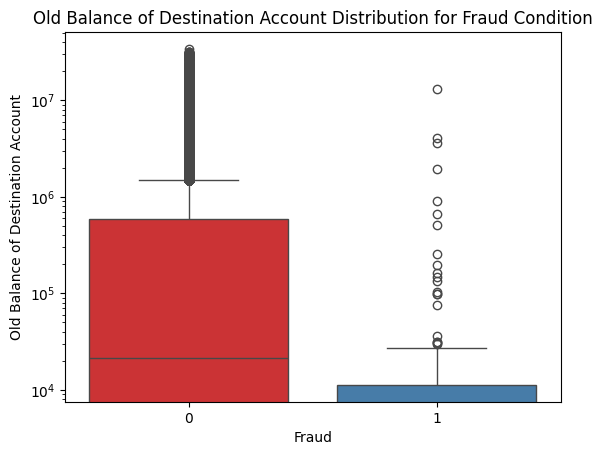

In [61]:
median_oldbalanceOrg_0 = fraud_0['oldbalanceDest'].median()
q1_oldbalanceOrg_0 = fraud_0['oldbalanceDest'].quantile(0.25)
q3_oldbalanceOrg_0 = fraud_0['oldbalanceDest'].quantile(0.75)
iqr_oldbalanceOrg_0 = q3_oldbalanceOrg_0 - q1_oldbalanceOrg_0
lower_limit_oldbalanceOrg_0 = max(0, q1_oldbalanceOrg_0 - 1.5 * iqr_oldbalanceOrg_0)
upper_limit_oldbalanceOrg_0 = q3_oldbalanceOrg_0 + 1.5 * iqr_oldbalanceOrg_0

print(f"'Old Balance of Destination Account when No Fraud: Median = {median_oldbalanceOrg_0}, Limits = [{lower_limit_oldbalanceOrg_0}, {upper_limit_oldbalanceOrg_0}]")

median_oldbalanceOrg_1 = fraud_1['oldbalanceDest'].median()
q1_oldbalanceOrg_1 = fraud_1['oldbalanceDest'].quantile(0.25)
q3_oldbalanceOrg_1 = fraud_1['oldbalanceDest'].quantile(0.75)
iqr_oldbalanceOrg_1 = q3_oldbalanceOrg_1 - q1_oldbalanceOrg_1
lower_limit_oldbalanceOrg_1 = max(0, q1_oldbalanceOrg_1 - 1.5 * iqr_oldbalanceOrg_1)
upper_limit_oldbalanceOrg_1 = q3_oldbalanceOrg_1 + 1.5 * iqr_oldbalanceOrg_1

print(f"Old Balance of Destination Account when Fraud: Median = {median_oldbalanceOrg_1}, Limits = [{lower_limit_oldbalanceOrg_1}, {upper_limit_oldbalanceOrg_1}]")

sns.boxplot(x='isFraud', y='oldbalanceDest', data=df_fraud,palette="Set1")
plt.xlabel("Fraud")
plt.ylabel("Old Balance of Destination Account")
plt.title("Old Balance of Destination Account Distribution for Fraud Condition")
plt.yscale('log')  
plt.show()

Destination Accounts's balance before the transaction when Fraud are usually **lower** than the No Fraud ones. The values when Fraud are commonly between 0 and 28.066.87 $, being the Median= 0. So, they are usually **empty** before the transaction. This could be helpful for **detecting Frauds**.

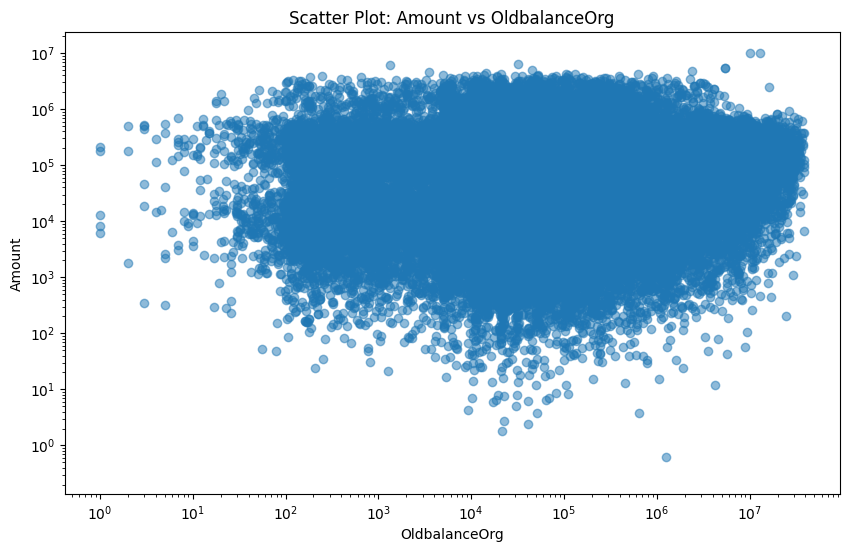

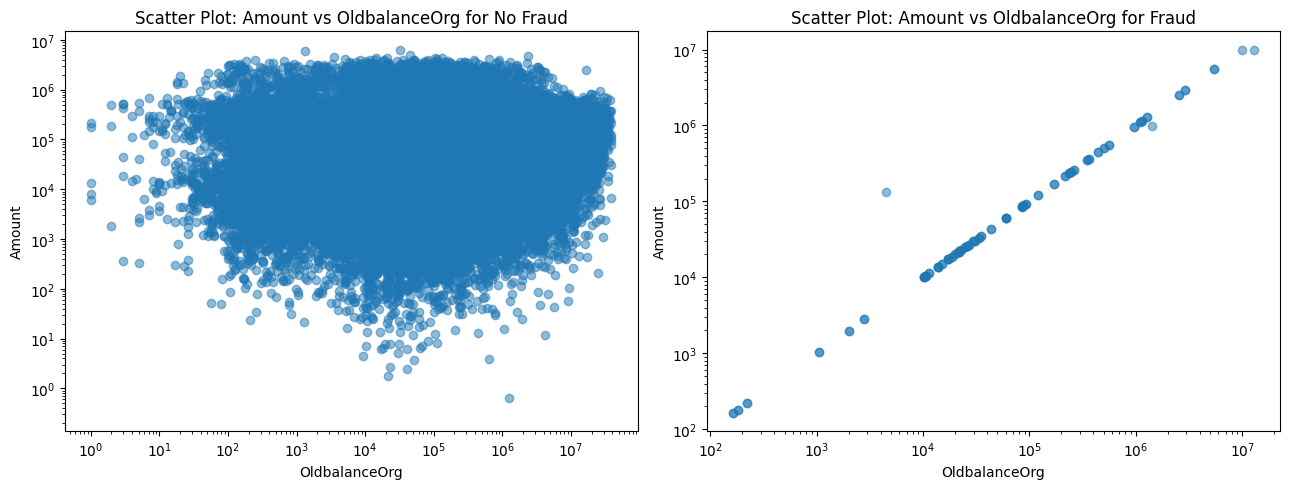

In [581]:
plt.figure(figsize=(10, 6))
plt.scatter(df_fraud['oldbalanceOrg'], df_fraud['amount'], alpha=0.5)

plt.title("Scatter Plot: Amount vs OldbalanceOrg")
plt.xlabel("OldbalanceOrg")
plt.ylabel("Amount")
plt.yscale('log') 
plt.xscale('log')
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

axes[0].scatter(df_no_fraud['oldbalanceOrg'], df_no_fraud['amount'], alpha=0.5)
axes[0].set_title('Scatter Plot: Amount vs OldbalanceOrg for No Fraud')
axes[0].set_xlabel('OldbalanceOrg')
axes[0].set_ylabel('Amount')
axes[0].set_yscale('log') 
axes[0].set_xscale('log')

axes[1].scatter(df_fraud_only['oldbalanceOrg'], df_fraud_only['amount'], alpha=0.5)
axes[1].set_title('Scatter Plot: Amount vs OldbalanceOrg for Fraud')
axes[1].set_xlabel('OldbalanceOrg')
axes[1].set_ylabel('Amount')
axes[1].set_yscale('log') 
axes[1].set_xscale('log')

plt.tight_layout()
plt.show()

It looks like every transaction takes **all the available amount** from the Origin Account when committing Fraud.

C:\Users\PC\AppData\Local\Temp\ipykernel_5440\724596301.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='type', y='amount', data=df_fraud,palette="Set2")


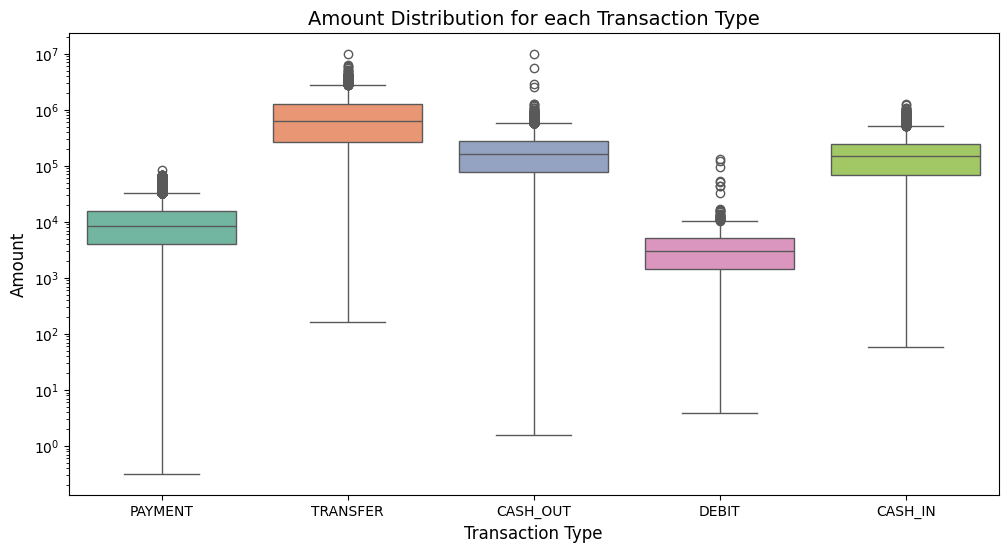

In [584]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='type', y='amount', data=df_fraud,palette="Set2")
plt.title("Amount Distribution for each Transaction Type", fontsize=14)
plt.xlabel("Transaction Type", fontsize=12)
plt.ylabel("Amount", fontsize=12)
plt.yscale('log') 
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_5440\2297050847.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0], x='type', y='amount', data=fraud_data, palette="Set1")
C:\Users\PC\AppData\Local\Temp\ipykernel_5440\2297050847.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1], x='type', y='amount', data=non_fraud_data, palette="Set2")


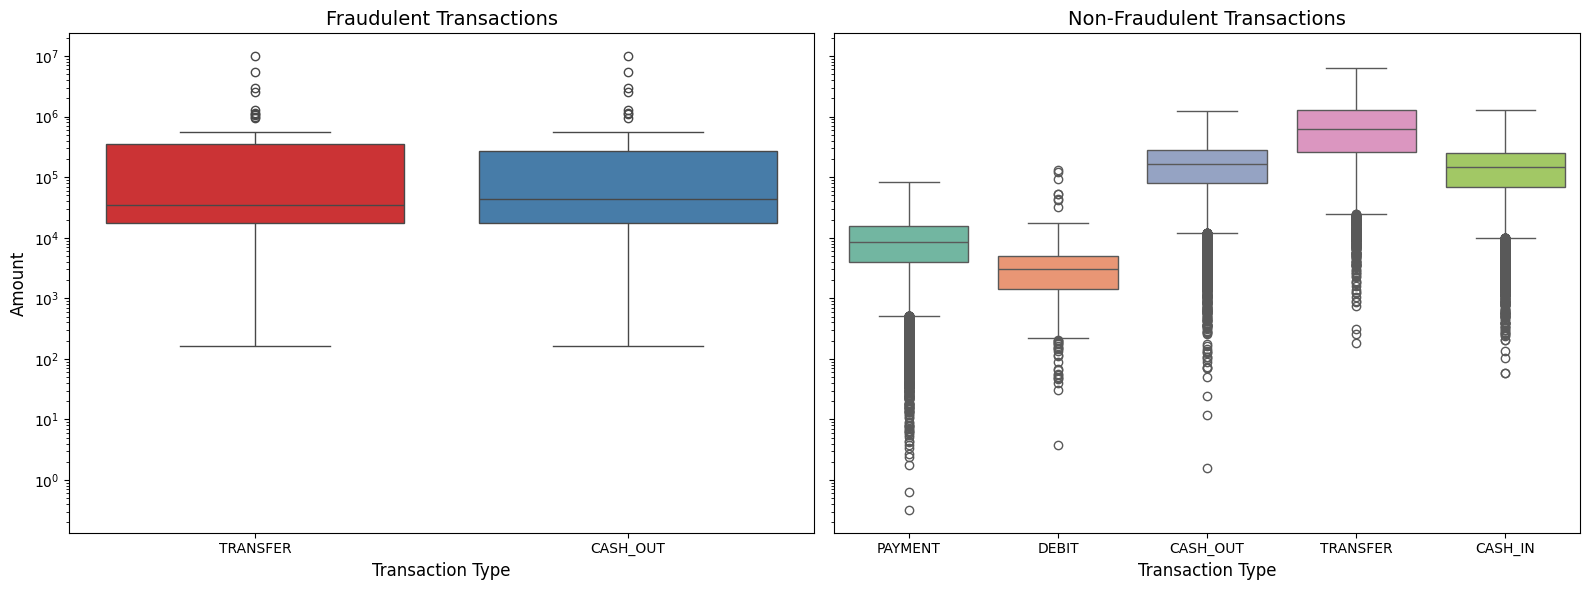

In [585]:
fraud_data = df_fraud[df_fraud['isFraud'] == 1]
non_fraud_data = df_fraud[df_fraud['isFraud'] == 0]

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

sns.boxplot(ax=axes[0], x='type', y='amount', data=fraud_data, palette="Set1")
axes[0].set_title("Fraudulent Transactions", fontsize=14)
axes[0].set_xlabel("Transaction Type", fontsize=12)
axes[0].set_ylabel("Amount", fontsize=12)
axes[0].set_yscale('log')

sns.boxplot(ax=axes[1], x='type', y='amount', data=non_fraud_data, palette="Set2")
axes[1].set_title("Non-Fraudulent Transactions", fontsize=14)
axes[1].set_xlabel("Transaction Type", fontsize=12)
axes[1].set_ylabel("Amount", fontsize=12)  
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

When committing Fraud, the transaction Amounts are usually **high amounts**. So this could helpful for detecting fraud, with transaction amounts higher than X value. Already was known that Frauds where comitted by Transfer and Cash Out transaction, and their distributions are quite **similar** for No Fraud transaction.

C:\Users\PC\AppData\Local\Temp\ipykernel_5440\2504482279.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='step', y='amount', data=df_fraud,palette="Set2")


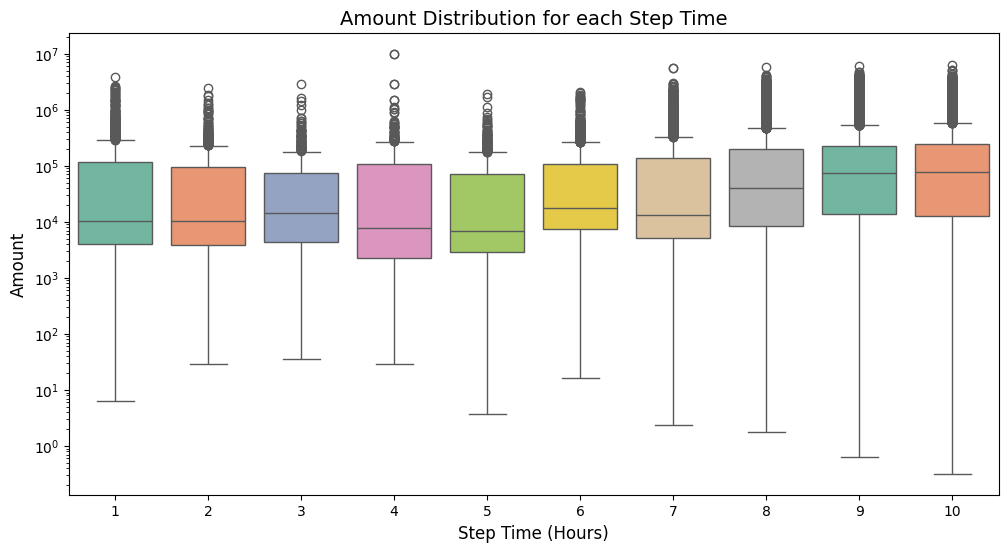

C:\Users\PC\AppData\Local\Temp\ipykernel_5440\2504482279.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[0], x='step', y='amount', data=fraud_data, palette="Set1")
C:\Users\PC\AppData\Local\Temp\ipykernel_5440\2504482279.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(ax=axes[1], x='step', y='amount', data=non_fraud_data, palette="Set2")


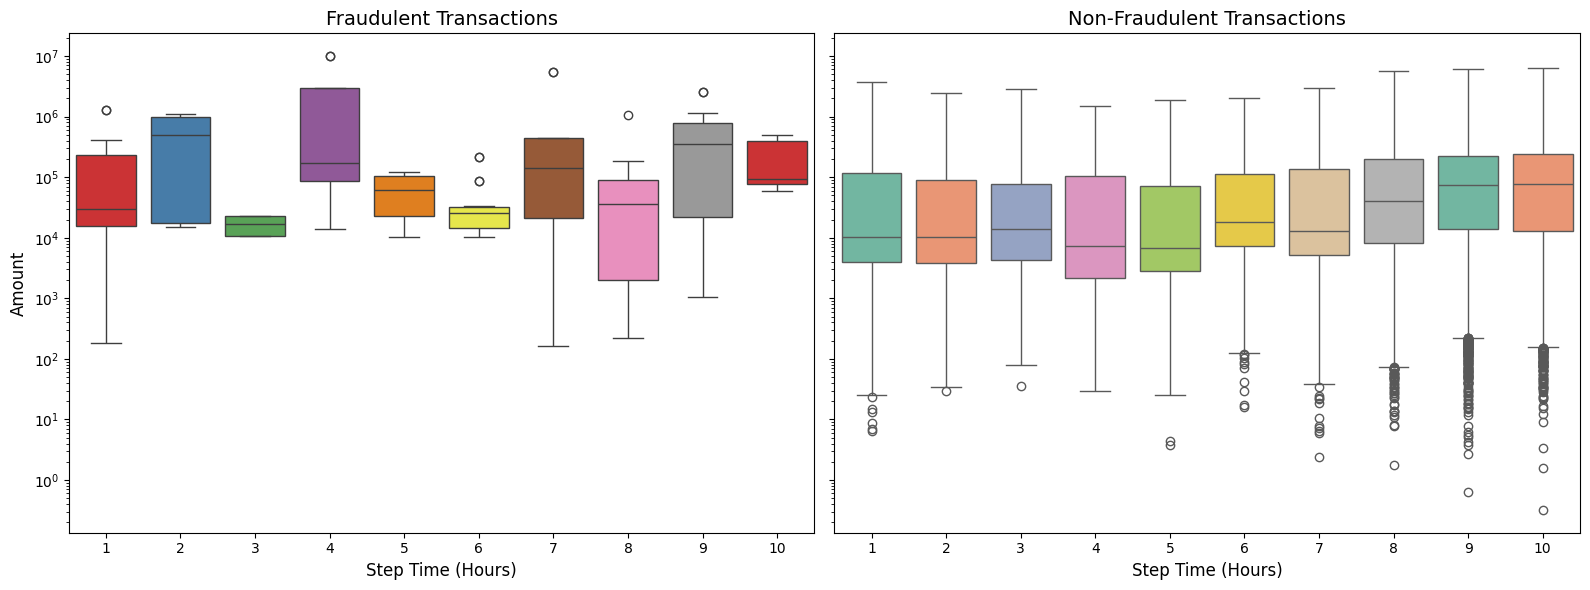

In [588]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='step', y='amount', data=df_fraud,palette="Set2")
plt.title("Amount Distribution for each Step Time", fontsize=14)
plt.xlabel("Step Time (Hours)", fontsize=12)
plt.ylabel("Amount", fontsize=12)
plt.yscale('log') 
plt.show()

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

sns.boxplot(ax=axes[0], x='step', y='amount', data=fraud_data, palette="Set1")
axes[0].set_title("Fraudulent Transactions", fontsize=14)
axes[0].set_xlabel("Step Time (Hours)", fontsize=12)
axes[0].set_ylabel("Amount", fontsize=12)
axes[0].set_yscale('log')

sns.boxplot(ax=axes[1], x='step', y='amount', data=non_fraud_data, palette="Set2")
axes[1].set_title("Non-Fraudulent Transactions", fontsize=14)
axes[1].set_xlabel("Step Time (Hours)", fontsize=12)
axes[1].set_ylabel("Amount", fontsize=12)  # Compartido por ambos subplots
axes[1].set_yscale('log')

plt.tight_layout()
plt.show()

Since fraud only occurs in Transfer and Cash Out transactions, the Amount distributions for each Step value are generally **higher**. 

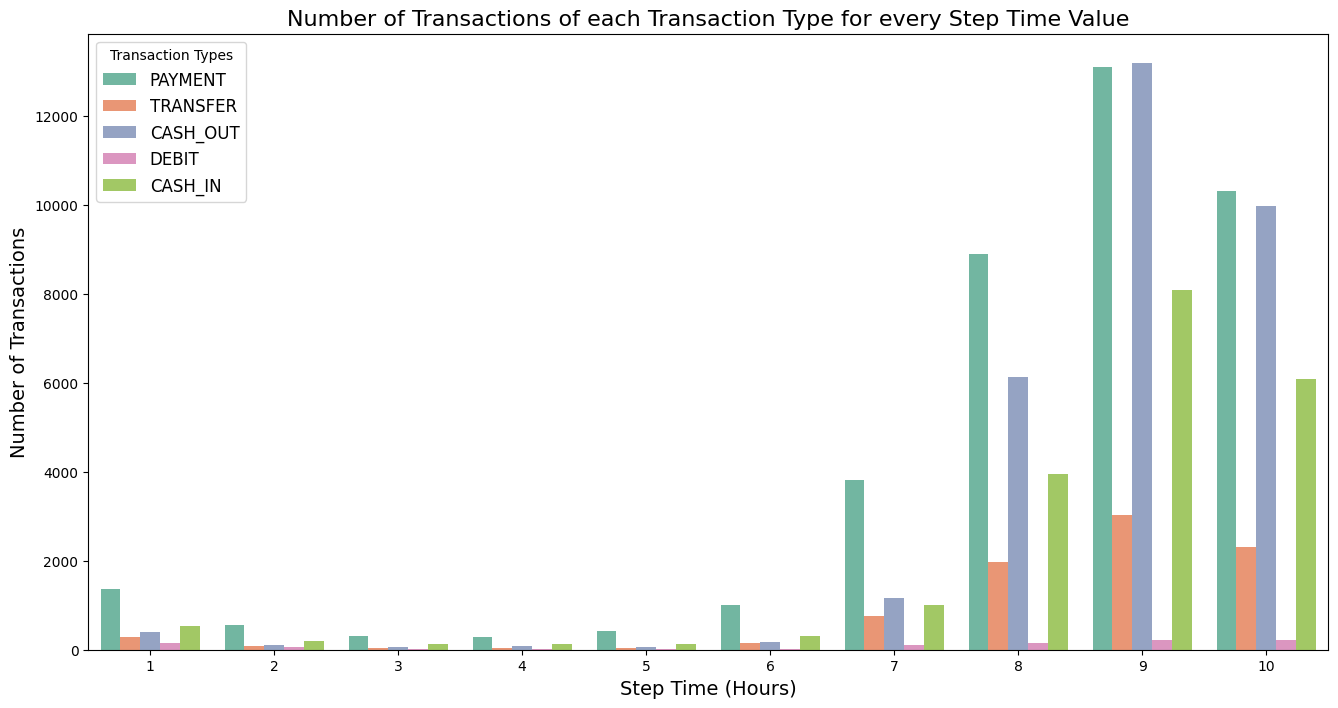

In [591]:
plt.figure(figsize=(16, 8))
sns.countplot(x='step', hue='type', data=df_fraud, palette="Set2")
plt.title("Number of Transactions of each Transaction Type for every Step Time Value", fontsize=16)
plt.xlabel("Step Time (Hours)", fontsize=14)
plt.ylabel("Number of Transactions", fontsize=14)
plt.legend(title="Transaction Types", fontsize=12)
plt.show()

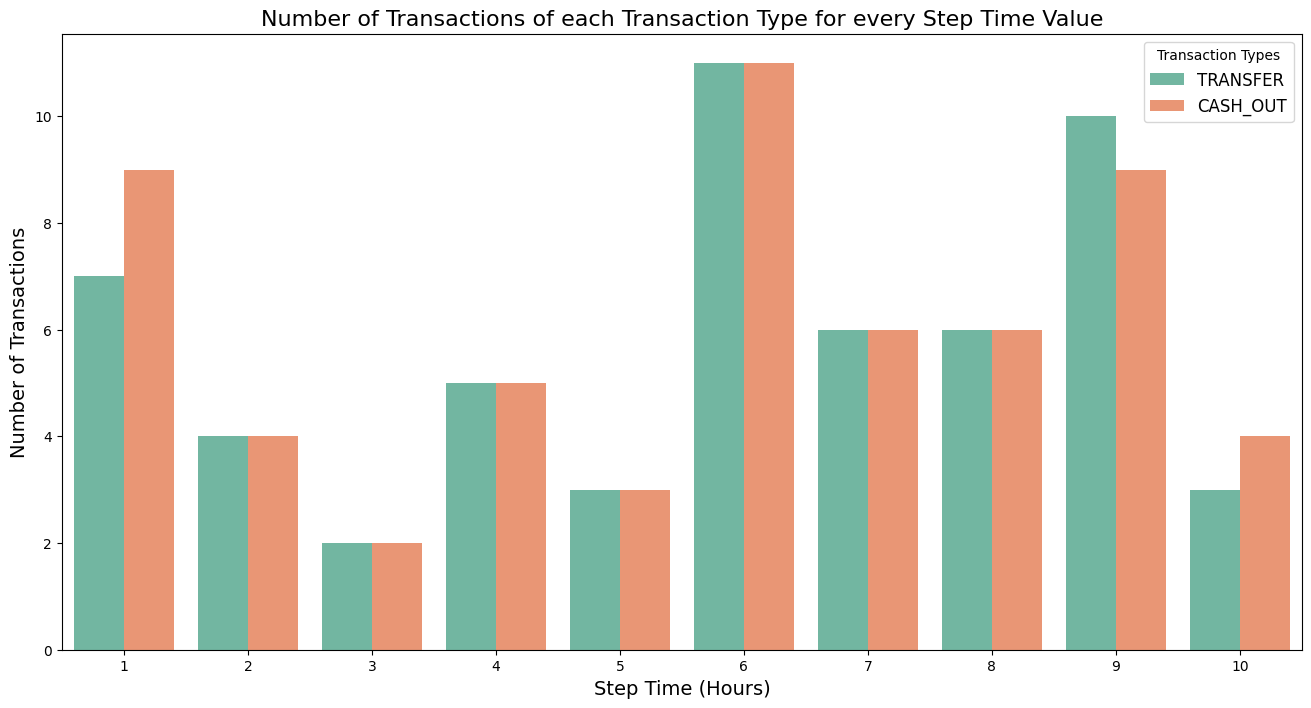

In [593]:
plt.figure(figsize=(16, 8))
sns.countplot(x='step', hue='type', data=fraud_data, palette="Set2")
plt.title("Number of Transactions of each Transaction Type for every Step Time Value", fontsize=16)
plt.xlabel("Step Time (Hours)", fontsize=14)
plt.ylabel("Number of Transactions", fontsize=14)
plt.legend(title="Transaction Types", fontsize=12)
plt.show()

Number of fraudulent Transfer and Cash Out Transactions are almost **equal** in every Step value when committing Fraud.

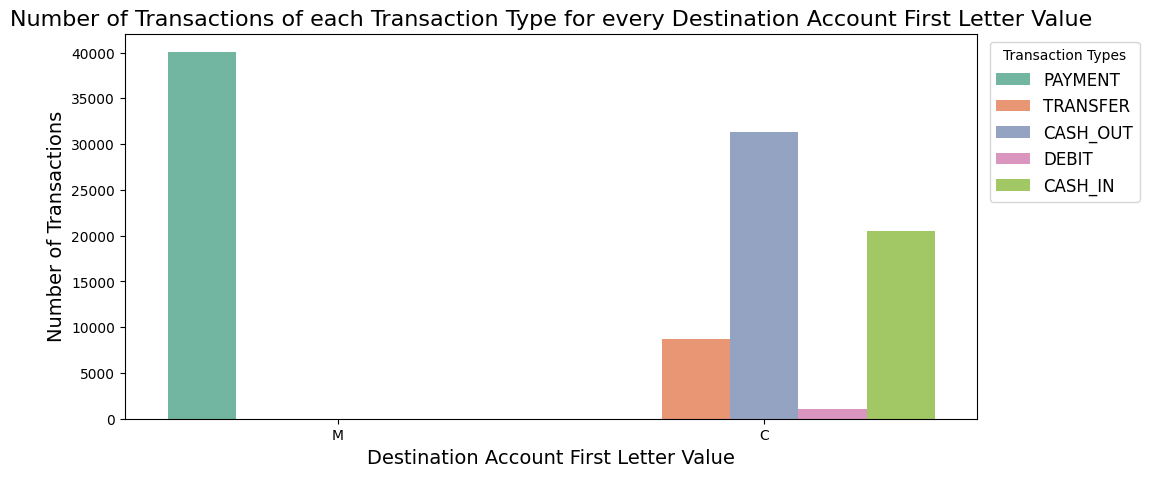

In [595]:
plt.figure(figsize=(11, 5))
sns.countplot(x='first_letter_nameDest', hue='type', data=df_fraud, palette="Set2")
plt.title("Number of Transactions of each Transaction Type for every Destination Account First Letter Value", fontsize=16)
plt.xlabel("Destination Account First Letter Value", fontsize=14)
plt.ylabel("Number of Transactions", fontsize=14)
plt.legend(title="Transaction Types", fontsize=12,loc='upper right', bbox_to_anchor=(1.2, 1))
plt.show()

As fraudulent destination Accounts only start with C, it´s not necessary to do the comparisson between fraud and no Fraud. We have a chart on top which shows the distribution of the Transaction Types for Fraudulent Destination Bank Accounts.

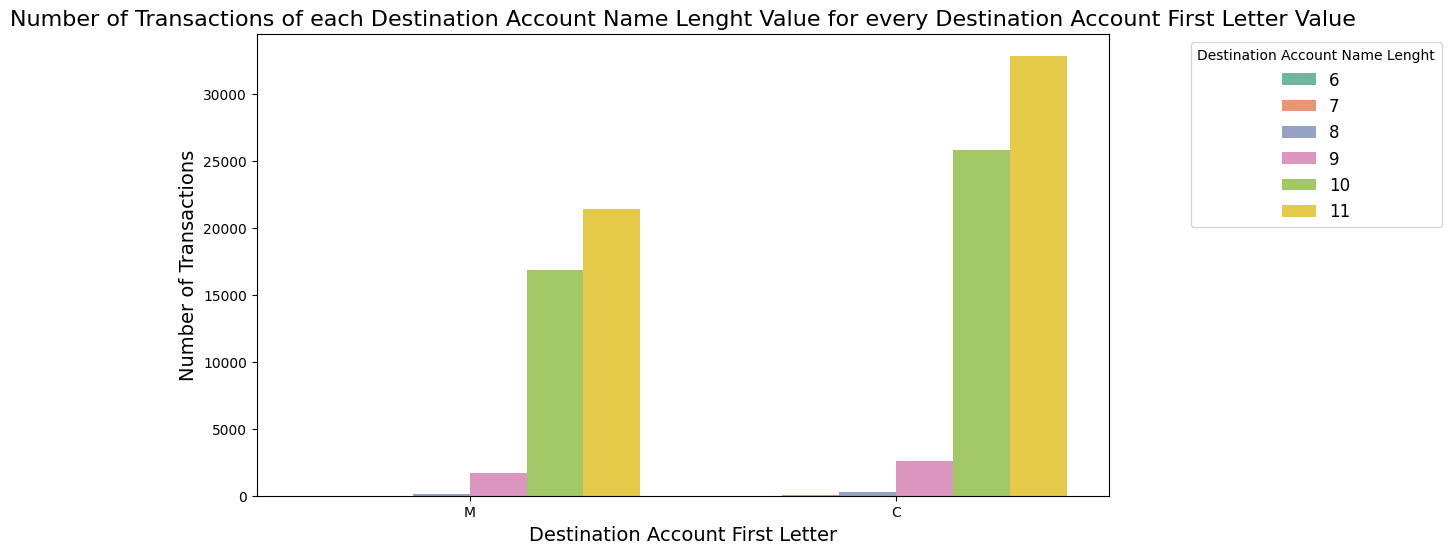

In [598]:
plt.figure(figsize=(11, 6))
sns.countplot(x='first_letter_nameDest', hue='nameOrig_length', data=df_fraud, palette="Set2")
plt.title("Number of Transactions of each Destination Account Name Lenght Value for every Destination Account First Letter Value", fontsize=16)
plt.xlabel("Destination Account First Letter", fontsize=14)
plt.ylabel("Number of Transactions", fontsize=14)
plt.legend(title="Destination Account Name Lenght", fontsize=12,loc='upper right', bbox_to_anchor=(1.4, 1))
plt.show()

As in the last section, fraudulent destination Accounts only start with C, it´s not necessary to do the comparisson between fraud and no Fraud. We have a chart on top which shows the distribution of the Name Length for Fraudulent Destination Bank Accounts.

# ML  Fraud Predicting Model

## Data Preprocessing

In [675]:
df_fraud_ml=df_fraud.drop(columns=['isFlaggedFraud','first_letter_nameOrig','nameOrig','nameDest'])

In [677]:
df_fraud_ml = pd.get_dummies(df_fraud_ml, columns=['type'])
#df_fraud_ml = pd.get_dummies(df_fraud_ml, columns=['step'])
df_fraud_ml = pd.get_dummies(df_fraud_ml, columns=['first_letter_nameDest'])
#df_fraud_ml['HasCrCard'] = df_fraud_ml['HasCrCard'].astype(int)
#df_fraud_ml['IsActiveMember'] = df_fraud_ml['IsActiveMember'].astype(int)
df_fraud_ml[['type_CASH_IN','type_CASH_OUT','type_DEBIT','type_PAYMENT','type_TRANSFER','first_letter_nameDest_C','first_letter_nameDest_M']]=df_fraud_ml[['type_CASH_IN','type_CASH_OUT','type_DEBIT','type_PAYMENT','type_TRANSFER','first_letter_nameDest_C','first_letter_nameDest_M']].astype(int)
display(df_fraud_ml.head(25))
#display(df_fraud_ml.columns)
print(df_fraud_ml.dtypes)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,nameDest_length,nameOrig_length,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,first_letter_nameDest_C,first_letter_nameDest_M
0,1,9839.64,170136.00,160296.36,0.0,0.00,0,11,11,0,0,0,1,0,0,1
1,1,1864.28,21249.00,19384.72,0.0,0.00,0,11,11,0,0,0,1,0,0,1
2,1,181.00,181.00,0.00,0.0,0.00,1,10,11,0,0,0,0,1,1,0
3,1,181.00,181.00,0.00,21182.0,0.00,1,9,10,0,1,0,0,0,1,0
4,1,11668.14,41554.00,29885.86,0.0,0.00,0,11,11,0,0,0,1,0,0,1
5,1,7817.71,53860.00,46042.29,0.0,0.00,0,10,9,0,0,0,1,0,0,1
6,1,7107.77,183195.00,176087.23,0.0,0.00,0,10,10,0,0,0,1,0,0,1
7,1,7861.64,176087.23,168225.59,0.0,0.00,0,10,11,0,0,0,1,0,0,1
8,1,4024.36,2671.00,0.00,0.0,0.00,0,11,11,0,0,0,1,0,0,1
9,1,5337.77,41720.00,36382.23,41898.0,40348.79,0,10,10,0,0,1,0,0,1,0


step                         int64
amount                     float64
oldbalanceOrg              float64
newbalanceOrig             float64
oldbalanceDest             float64
newbalanceDest             float64
isFraud                      int64
nameDest_length              int64
nameOrig_length              int64
type_CASH_IN                 int64
type_CASH_OUT                int64
type_DEBIT                   int64
type_PAYMENT                 int64
type_TRANSFER                int64
first_letter_nameDest_C      int64
first_letter_nameDest_M      int64
dtype: object


In [679]:
scaler = StandardScaler()
df_fraud_ml[['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','nameDest_length','nameOrig_length']]=scaler.fit_transform(df_fraud_ml[['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','nameDest_length','nameOrig_length']])
display(df_fraud_ml.head())

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,nameDest_length,nameOrig_length,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,first_letter_nameDest_C,first_letter_nameDest_M
0,-4.132243,-0.476063,-0.260478,-0.266174,-0.367111,-0.423197,0,0.849667,0.856557,0,0,0,1,0,0,1
1,-4.132243,-0.499179,-0.313097,-0.315319,-0.367111,-0.423197,0,0.849667,0.856557,0,0,0,1,0,0,1
2,-4.132243,-0.504058,-0.320542,-0.322079,-0.367111,-0.423197,1,-0.802435,0.856557,0,0,0,0,1,1,0
3,-4.132243,-0.504058,-0.320542,-0.322079,-0.358285,-0.423197,1,-2.454538,-0.795068,0,1,0,0,0,1,0
4,-4.132243,-0.470763,-0.305921,-0.311656,-0.367111,-0.423197,0,0.849667,0.856557,0,0,0,1,0,0,1


In [681]:
X=df_fraud_ml.drop(columns='isFraud')
y=df_fraud_ml['isFraud']
print(X.shape,y.shape)
print(y.value_counts())

(101613, 15) (101613,)
isFraud
0    101497
1       116
Name: count, dtype: int64


The number of values for each class is highly **imbalanced**. The **SMOTE** technique will be used to generate synthetic samples for the minority class, aiming to address class imbalance.

### Train Test Split

The dataset is split into training and testing sets before applying the SMOTE function, ensuring that the test data remains unaltered and its integrity is preserved for unbiased evaluation. Stratify parameter to ensure minorit class values.

In [683]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train size:", X_train.shape, y_train.shape)
print("Test size:", X_test.shape, y_test.shape)

Train size: (81290, 15) (81290,)
Test size: (20323, 15) (20323,)


### SMOTE

In [686]:
smote = SMOTE(random_state=42)

X_train, y_train = smote.fit_resample(X_train,y_train)

df_balanced = pd.concat([y_train, X_train], axis=1)

print(X_train.shape,y_train.shape)
print(y_train.value_counts())

(162394, 15) (162394,)
isFraud
0    81197
1    81197
Name: count, dtype: int64


After applying the SMOTE function, the classes in the training split are now **balanced**.

In [689]:
results = {}

## Models

### Logistic Regression

C:\Users\PC\anaconda3\envs\bank_churn\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuraccy in every fold: [0.94827427 0.94999846 0.94812032 0.94741217 0.94796478]
Mean Accuraccy over the 5 folds: 0.9484

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     20300
           1       0.02      0.96      0.03        23

    accuracy                           0.94     20323
   macro avg       0.51      0.95      0.50     20323
weighted avg       1.00      0.94      0.97     20323



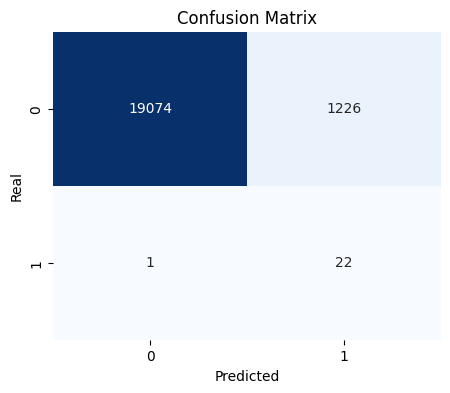

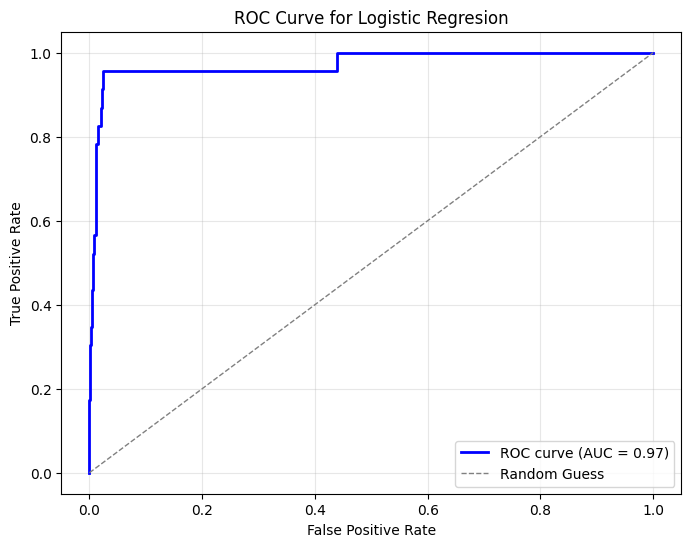

In [695]:
name='Logistic Regresion'
lr = LogisticRegression()
kf = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(lr, X_train, y_train, cv=5, scoring='accuracy')
print(f'Accuraccy in every fold: {scores}')
print(f'Mean Accuraccy over the {len(scores)} folds: {np.mean(scores):.4f}')

lr.fit(X_train, y_train)
y_pred_test = lr.predict(X_test)

print("\nTest Classification Report:")
print(classification_report(y_test, y_pred_test))
classification_rep = classification_report(y_test, y_pred_test, output_dict=True)

results[name] = {
        "Classification Report": classification_rep
    }

cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.show()

y_pred_prob = lr.predict_proba(X_test)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {name}')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

### Decision Tree

Accuraccy in every fold: [0.99849133 0.99876843 0.99876843 0.99898396 0.99904551]
Mean Accuraccy over the 5 folds: 0.9988

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20300
           1       0.30      0.52      0.38        23

    accuracy                           1.00     20323
   macro avg       0.65      0.76      0.69     20323
weighted avg       1.00      1.00      1.00     20323



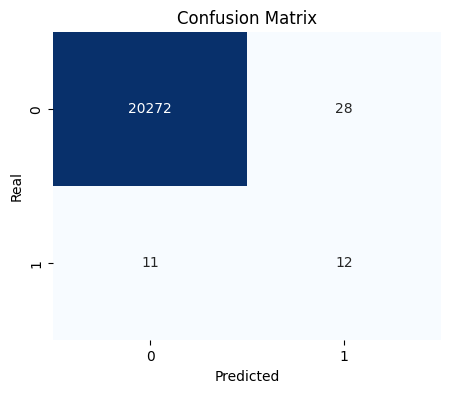

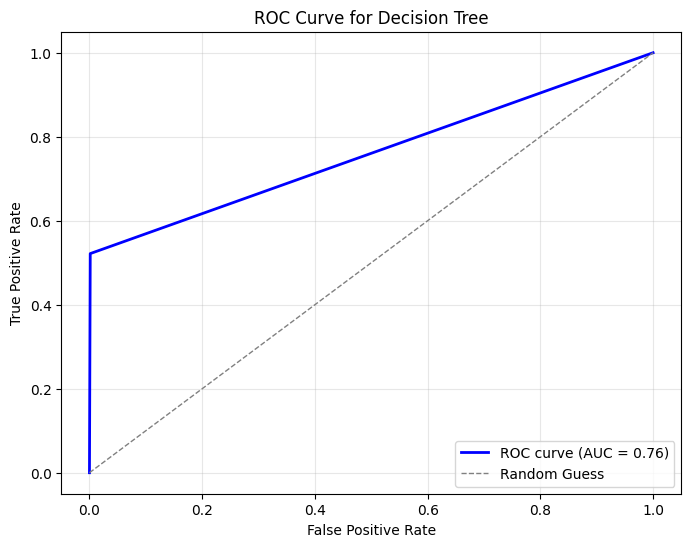

In [697]:
name='Decision Tree'

tree = DecisionTreeClassifier(random_state=42)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(tree, X_train, y_train, cv=5, scoring='accuracy')
print(f'Accuraccy in every fold: {scores}')
print(f'Mean Accuraccy over the {len(scores)} folds: {np.mean(scores):.4f}')

tree.fit(X_train, y_train)
y_pred_test = tree.predict(X_test)

print("\nTest Classification Report:")
print(classification_report(y_test, y_pred_test))
classification_rep = classification_report(y_test, y_pred_test, output_dict=True)

results[name] = {
        "Classification Report": classification_rep
    }

cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.show()

y_pred_prob = tree.predict_proba(X_test)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {name}')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

### Random Forest

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best parameters:  {'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Best score:  0.999735211816185
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20300
           1       0.70      0.61      0.65        23

    accuracy                           1.00     20323
   macro avg       0.85      0.80      0.83     20323
weighted avg       1.00      1.00      1.00     20323



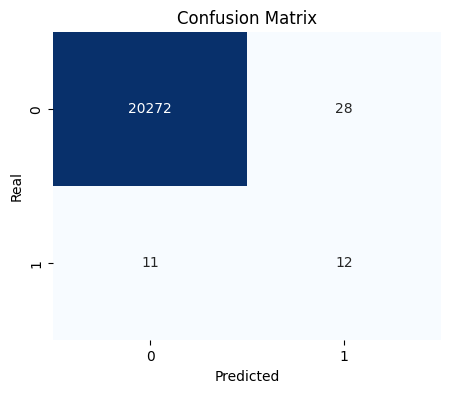

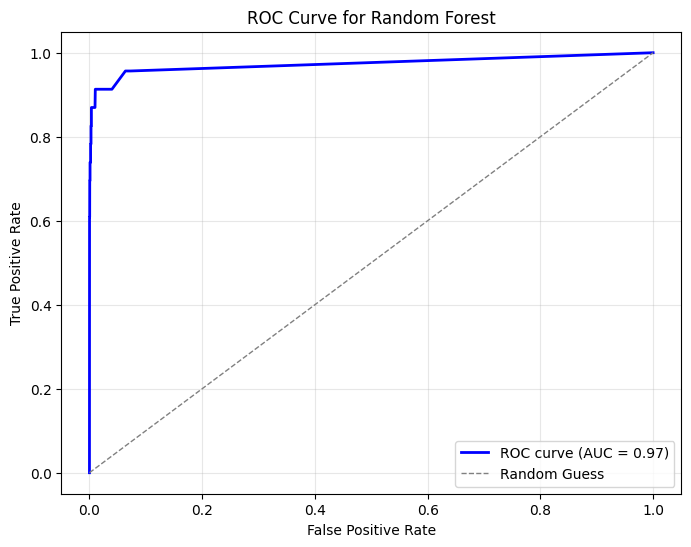

In [699]:
name = 'Random Forest'

rf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200], 
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)
y_pred_rf_grid = grid_search.predict(X_test)
print(classification_report(y_test, y_pred_rf_grid))
classification_rep = classification_report(y_test, y_pred_test, output_dict=True)

results[name] = {
        "Classification Report": classification_rep
    }

cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.show()


y_pred_prob = grid_search.predict_proba(X_test)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {name}')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

### XGBoost

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best parameters:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 0.8}
Best score:  0.999599739285749

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20300
           1       0.64      0.70      0.67        23

    accuracy                           1.00     20323
   macro avg       0.82      0.85      0.83     20323
weighted avg       1.00      1.00      1.00     20323



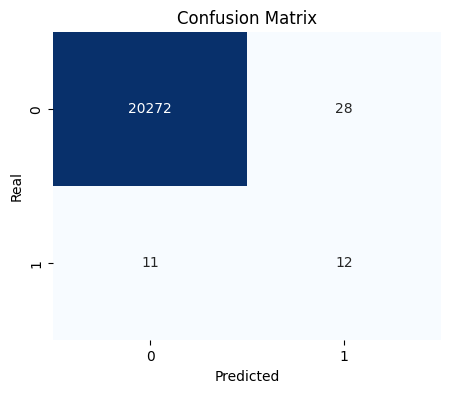

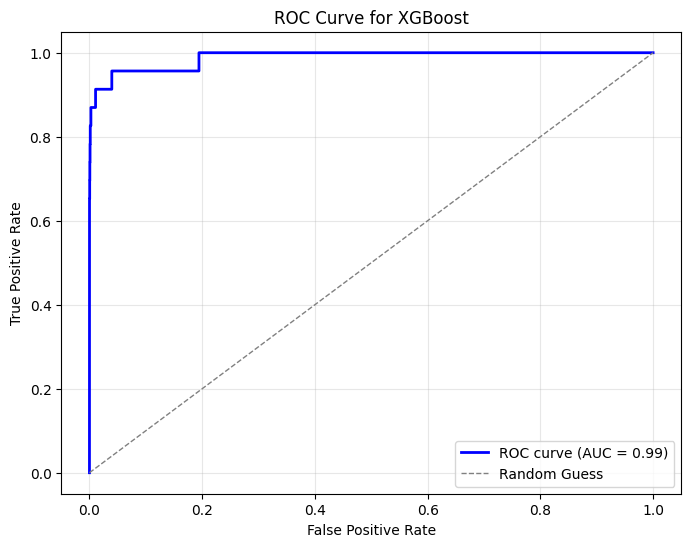

In [701]:
name = 'XGBoost'

xgb_model = xgb.XGBClassifier(random_state=42)

param_grid = {
    'n_estimators': [50, 100, 200], 
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')
grid_search.fit(X_train, y_train)

print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

y_pred_xgb_grid = grid_search.predict(X_test)
print("\nTest Classification Report:")
print(classification_report(y_test, y_pred_xgb_grid))

classification_rep = classification_report(y_test, y_pred_xgb_grid, output_dict=True)

results[name] = {
    "Classification Report": classification_rep
}

cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.show()

y_pred_prob = grid_search.predict_proba(X_test)[:, 1]  #
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {name}')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

### KNeighbors

Accuraccy in every fold: [0.99559716 0.99541242 0.99565873 0.99470427 0.99575097]
Mean Accuraccy over the 5 folds: 0.9954

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00     20300
           1       0.04      0.26      0.06        23

    accuracy                           0.99     20323
   macro avg       0.52      0.63      0.53     20323
weighted avg       1.00      0.99      0.99     20323



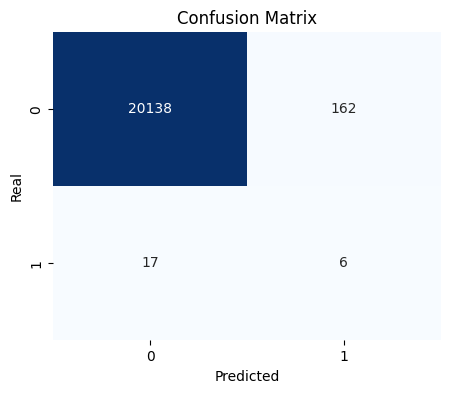

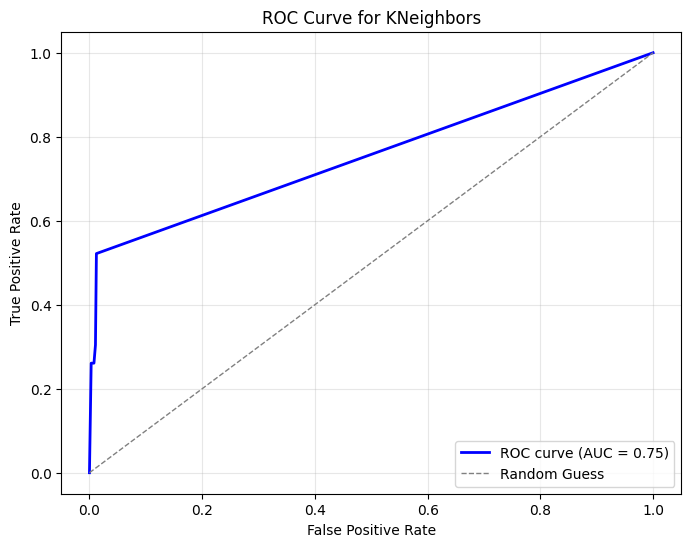

In [704]:
name ='KNeighbors'

knn = KNeighborsClassifier(n_neighbors=5)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
print(f'Accuraccy in every fold: {scores}')
print(f'Mean Accuraccy over the {len(scores)} folds: {np.mean(scores):.4f}')

knn.fit(X_train, y_train)
y_pred_test = knn.predict(X_test)

print("\nTest Classification Report:")
print(classification_report(y_test, y_pred_test))
classification_rep = classification_report(y_test, y_pred_test, output_dict=True)

results[name] = {
        "Classification Report": classification_rep
    }

cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.show()


y_pred_prob = knn.predict_proba(X_test)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {name}')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

### Support Vector Machine

Accuraccy in every fold: [0.96419225 0.96511592 0.96533144 0.9649004  0.9636985 ]
Mean Accuraccy over the 5 folds: 0.9646

Test Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     20300
           1       0.02      0.83      0.04        23

    accuracy                           0.95     20323
   macro avg       0.51      0.89      0.51     20323
weighted avg       1.00      0.95      0.97     20323



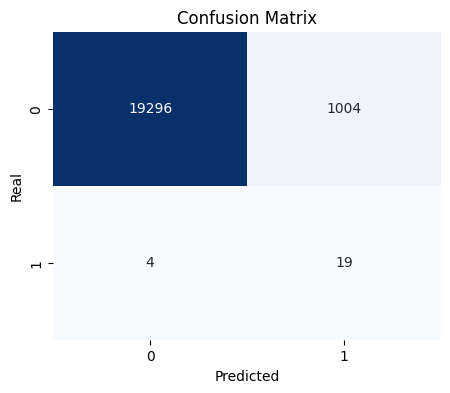

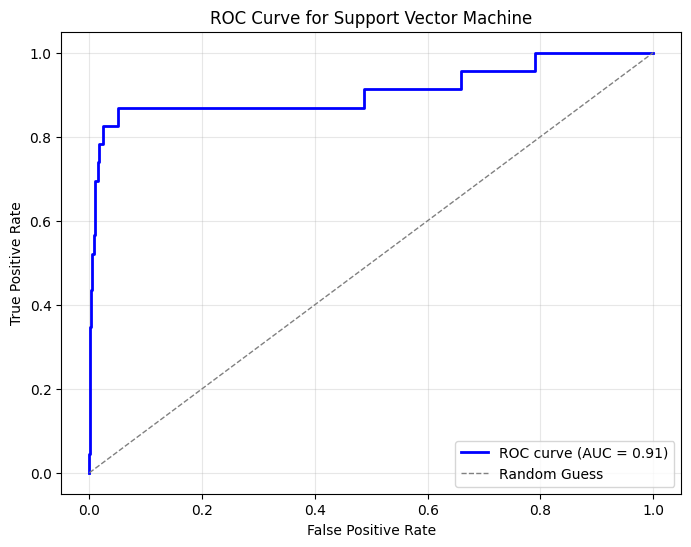

In [706]:
name ='Support Vector Machine'

svm = SVC(probability=True, random_state=42)

scores = cross_val_score(svm, X_train, y_train, cv=5, scoring='accuracy')
print(f'Accuraccy in every fold: {scores}')
print(f'Mean Accuraccy over the {len(scores)} folds: {np.mean(scores):.4f}')

svm.fit(X_train, y_train)
y_pred_test = svm.predict(X_test)

print("\nTest Classification Report:")
print(classification_report(y_test, y_pred_test))
classification_rep = classification_report(y_test, y_pred_test, output_dict=True)

results[name] = {
        "Classification Report": classification_rep
    }

cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Real")
plt.show()


y_pred_prob = svm.predict_proba(X_test)[:, 1] 
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve for {name}')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

## Results Comparisson

In [708]:
data = []
for model_name, metrics in results.items():
    classification_report_ = metrics["Classification Report"]
    row = {
        "Model": model_name,
        "Accuracy": classification_report_["accuracy"],
        "Macro Precision": classification_report_["macro avg"]["precision"],
        "Macro Recall": classification_report_["macro avg"]["recall"],
        "Macro F1-Score": classification_report_["macro avg"]["f1-score"],
        "Weighted Precision": classification_report_["weighted avg"]["precision"],
        "Weighted Recall": classification_report_["weighted avg"]["recall"],
        "Weighted F1-Score": classification_report_["weighted avg"]["f1-score"],
    }
    data.append(row)

df_results = pd.DataFrame(data)

display(df_results)

,Model,Accuracy,Macro Precision,Macro Recall,Macro F1-Score,Weighted Precision,Weighted Recall,Weighted F1-Score
0,Logistic Regresion,0.939625,0.508788,0.948064,0.501728,0.998836,0.939625,0.967781
1,Decision Tree,0.998081,0.649729,0.760180,0.689996,0.998666,0.998081,0.998340
2,Random Forest,0.998081,0.649729,0.760180,0.689996,0.998666,0.998081,0.998340
3,XGBoost,0.999213,0.819828,0.847604,0.833136,0.999248,0.999213,0.999229
4,KNeighbors,0.991192,0.517435,0.626445,0.529201,0.998066,0.991192,0.994520
5,Support Vector Machine,0.950401,0.509183,0.888314,0.505437,0.998682,0.950401,0.973484
